In [23]:
# importing libraries
import math
import tensorflow as tf
import keras
from keras.layers import *
import numpy as np
import random
import io
import os
from sklearn.model_selection import train_test_split
from keras.activations import tanh, softmax, sigmoid
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow as tf
import random
import os
import keras
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import (
    LSTM,
    LSTMCell,
    Input,
    Dense,
    concatenate,
    TimeDistributed,
    Flatten,
    Dropout,
    Masking,
    RepeatVector,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    multiply,
    Permute,
    Concatenate,
    Conv2D,
    Add,
    Activation,
    Lambda,
    BatchNormalization
)
from keras import backend as K, Model
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [24]:
# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

if gpus:
    try:
        # Select the first GPU (index 0)
        tf.config.set_visible_devices(gpus[5], 'GPU')

        # Optionally, limit GPU memory growth (prevents TensorFlow from consuming all GPU memory)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print("Using GPU:", gpus[5])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]
Using GPU: PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')


In [25]:
# soft object
soft = np.asarray([1, 0])
# hard object
hard = np.asarray([0, 1])

In [26]:
# reading a numpy file
data_dir = './train_val_data'
samples_per_window = 30

def read_npy_files(directory):
  data = []
  labels = []
  for filename in os.listdir(directory):
    if filename.endswith(".npy"):
      base_name = os.path.splitext(filename)[0]
      data.append(np.load(os.path.join(directory, filename), allow_pickle = True))
      # print(np.asarray(data).shape)
      # for labelling
      label = []
      objects = ['phone cover', 'rubber', 'bottle']
      if any(object in filename for object in objects):
          label.append(np.tile(soft, (samples_per_window, 1)))
      else:
          label.append(np.tile(hard, (samples_per_window, 1)))
      label = np.asarray(label).reshape(samples_per_window, 2)
      # print(np.asarray(label).shape)
      labels.append(np.asarray(label))
  return data, labels

all_data, labels = read_npy_files(data_dir)

# converting to numpy array
all_data = np.asarray(all_data)[:, :, :, 1:]
labels = np.asarray(labels)

In [27]:
train_all_data = []
val_all_data = []
test_all_data =[]
train_labels = []
val_labels = []
test_labels = []
total_samples = 8
val_samples = 1
test_samples = 1
train_samples = total_samples - val_samples - test_samples


for data in all_data:
  for i in range(train_samples):
    train_all_data.append(data[i])
  for i in range(val_samples):
    val_all_data.append(data[train_samples + i])
  for i in range(test_samples):
    test_all_data.append(data[train_samples + val_samples + i])

for label in labels:
  # label = np.expand_dims(label[1, :], axis = 0)
  # print(np.asarray(label).shape)
  for i in range(train_samples):
    train_labels.append(label[1, :])
  for i in range(val_samples):
    val_labels.append(label[1, :])
  for i in range(test_samples):
    test_labels.append(label[1, :])

In [28]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + tf.keras.backend.epsilon()))
    return f1

custom_objects = {'f1_score': f1_score}

model = load_model('checkpoint_model.keras', custom_objects=custom_objects)

In [29]:
test_data_tf = tf.convert_to_tensor(test_all_data)
test_labels_tf = tf.convert_to_tensor(test_labels)

In [30]:
test_data_tf.shape

TensorShape([12, 30, 3])

In [31]:
test_labels_tf.shape

TensorShape([12, 2])

In [32]:
# Evaluate the model on the test data
loss, accuracy, precision, recall, f1_score = model.evaluate(test_data_tf, test_labels_tf)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test F-Score: {f1_score}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8333 - f1_score: 0.8333 - loss: 0.2784 - precision_1: 0.8333 - recall_1: 0.8333
Test Loss: 0.2783912420272827
Test Accuracy: 0.8333333134651184
Test F-Score: 0.8333332538604736


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step


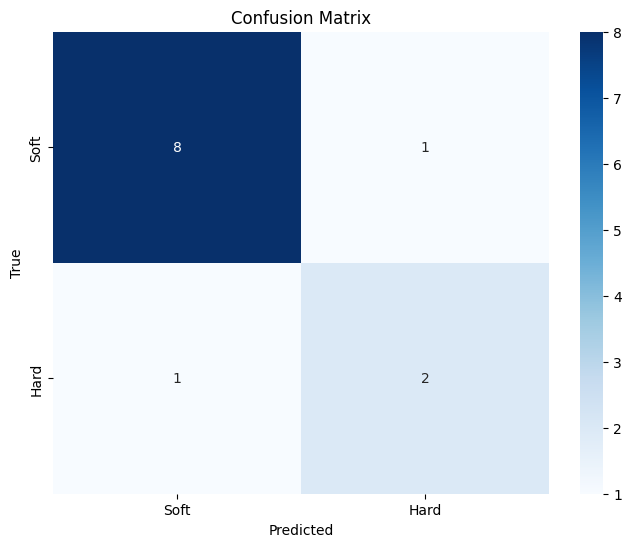

In [33]:
test_pred_tf = model.predict(test_data_tf)

# print(test_pred_tf.shape)
# print(test_labels_tf.shape)

test_pred_tf = np.argmax(test_pred_tf, axis=1)
test_labels_tf = np.argmax(test_labels_tf, axis=1)

# print(test_pred_tf.shape)
# print(test_labels_tf.shape)

cm = confusion_matrix(test_labels_tf, test_pred_tf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Soft', 'Hard'], yticklabels=['Soft', 'Hard'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()